### This jupyter notebooks provides the code to for using the CWT and scaleograms to map the behavior of dynamic systems.. 
### To get some more background information, please have a look at the accompanying blog-post:
### http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

In [1]:
import os
import pywt
#from wavelets.wave_python.waveletFunctions import *
import itertools
import numpy as np
import pandas as pd
from scipy.fftpack import fft
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

## 0. Load the el-Nino time-series dataset

In [2]:
dataset = "https://raw.githubusercontent.com/taspinar/siml/master/datasets/sst_nino3.dat.txt"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()

## 1. Plot the el-Nino time-series dataset

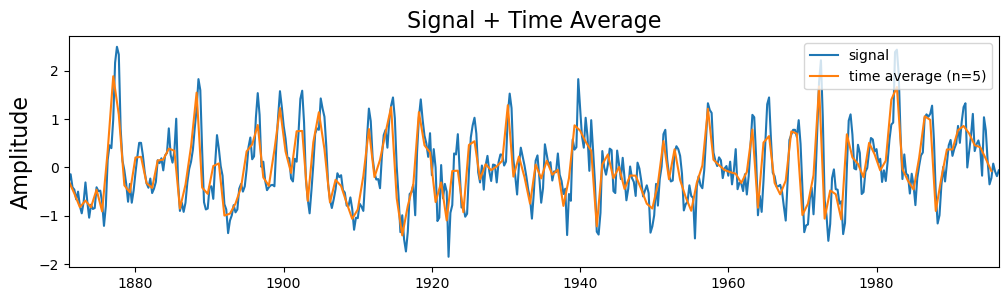

In [3]:
# First lets load the el-Nino dataset, and plot it together with its time-average

def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')

fig, ax = plt.subplots(figsize=(12,3))
plot_signal_plus_average(ax, time, signal, average_over = 3)
plt.show()

## 2. Plot the Fourier Transform of the el-Nino dataset

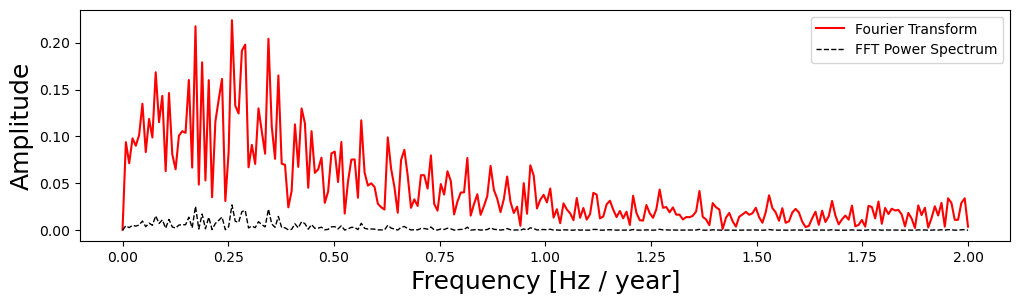

In [4]:
def get_fft_values(y_values, T, N, f_s):
    N2 = 2 ** (int(np.log2(N)) + 1) # round up to next highest power of 2
    f_values = np.linspace(0.0, 1.0/(2.0*T), N2//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N2 * np.abs(fft_values_[0:N2//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel('Frequency [Hz / year]', fontsize=18)
ax.set_ylabel('Amplitude', fontsize=18)
plot_fft_plus_power(ax, time, signal)
plt.show()

## 3. Plot the Scaleogram using the Continuous Wavelet Transform

C:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


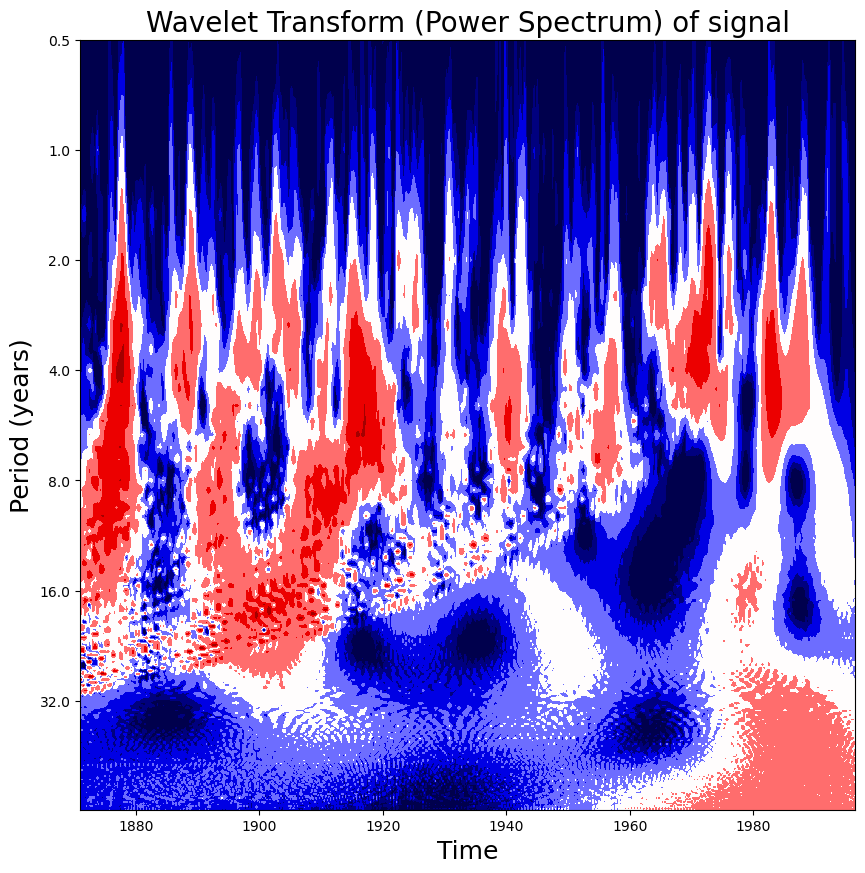

In [5]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

scales = np.arange(1, 128)
title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

fig, ax = plt.subplots(figsize=(10, 10))
plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
plt.show()

## 4. Extra Content: 
## Plot all of the above in one figure

C:\Users\14902\AppData\Local\Temp\ipykernel_26288\1361905880.py:20: RuntimeWarning: divide by zero encountered in divide
  scales = 1./f_values


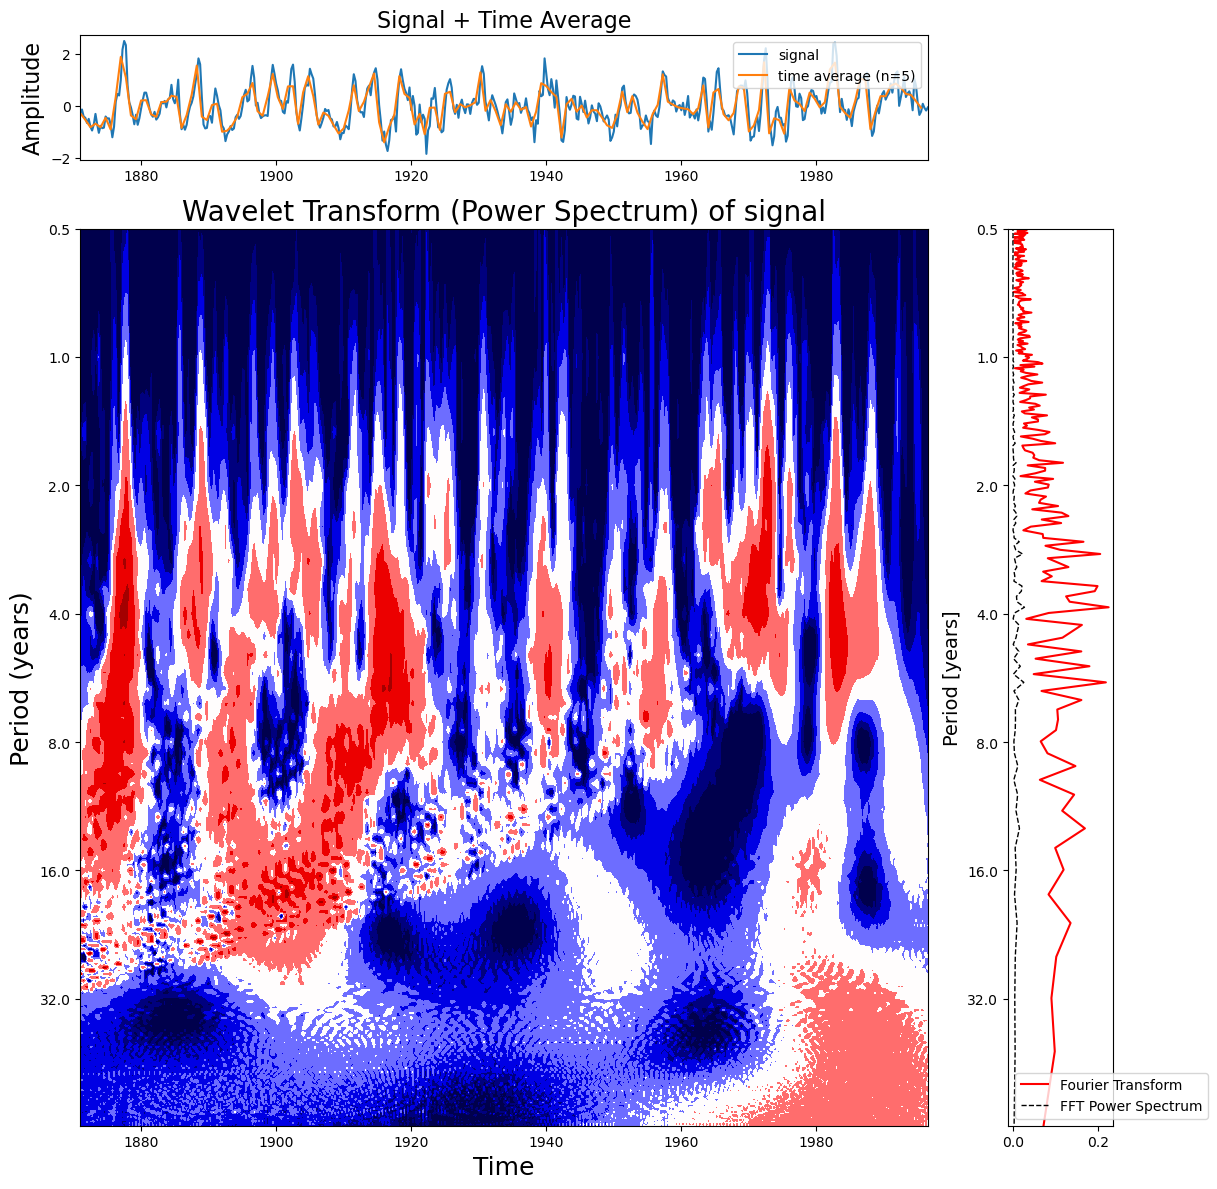

In [6]:
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[0, 0:5])
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
bottom_right_ax = fig.add_subplot(spec[1:, 5])

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

Also have a look at: http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/

# my

In [260]:
time=np.linspace(-1,1,2000,endpoint=True)
signal=np.cos(2*np.pi*(1/0.01)*time)+np.cos(2*np.pi*(1/0.02+100*time)*time)

In [261]:
dt = time[1] - time[0]
waveletname='cmor'
scales = np.arange(1, len(time)/5)
[coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, sampling_period=dt)


period = 1. / frequencies
power = (abs(coefficients)) ** 2

levels =np.linspace(start=-4,stop=3,endpoint=True)

C:\Users\14902\anaconda3\envs\sdo2022\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


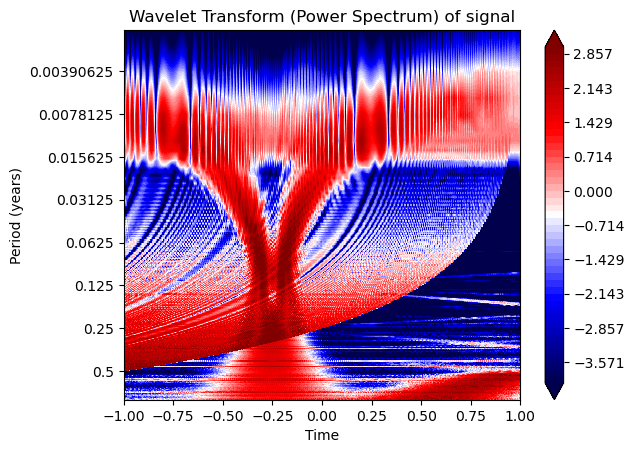

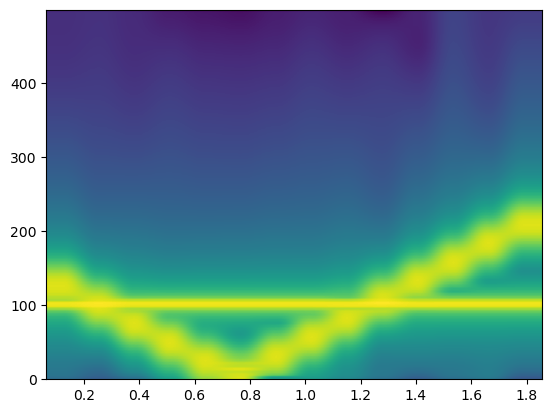

In [262]:
fig, ax = plt.subplots()
im=ax.contourf(time, np.log2(period), np.log2(power),  levels=levels,
            extend='both',cmap='seismic')
plt.colorbar(im)


yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))

ax.set_yticks(np.log2(yticks))
ax.set_yticklabels(yticks)
ax.invert_yaxis()
ax.set_title('Wavelet Transform (Power Spectrum) of signal')
ax.set_ylabel('Period (years)')
ax.set_xlabel('Time')
# ylim = ax.get_ylim()
# ax.set_ylim(ylim[0], -1)

fig, ax = plt.subplots()
ax.specgram(signal,Fs=1/dt);

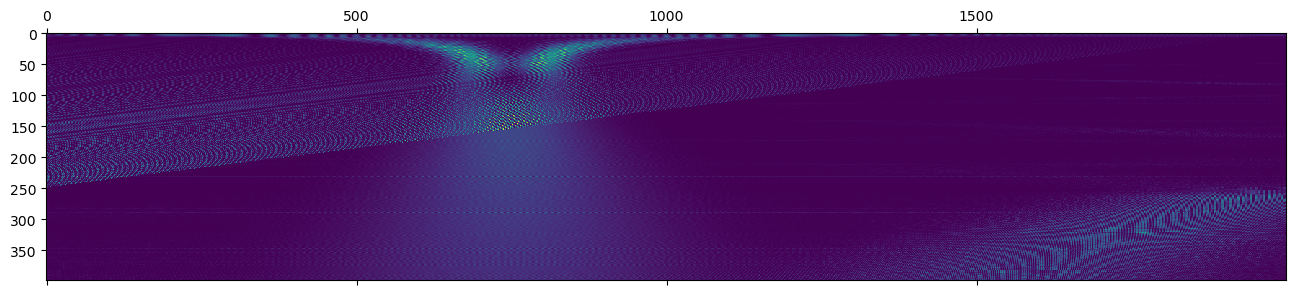

In [263]:
plt.matshow(power)

In [242]:
period[0],period[-1]

(0.002001000500250205, 1.9989994997499552)

In [204]:
np.log2(yticks)

array([-8., -7., -6., -5., -4., -3., -2., -1.,  0.])

In [191]:
(ylim[0], -1)

(-1.976378069972404, -1)

In [142]:
yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))

ax.set_yticks(np.log2(yticks))
ax.set_yticklabels(yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

(5.9886846867721655, -1.0)

In [43]:
ax.get_yticks()

array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140.])

In [46]:
yticks

array([ 0.5,  1. ,  2. ,  4. ,  8. , 16. , 32. ])

In [47]:
frequencies

array([2.        , 1.        , 0.66666667, 0.5       , 0.4       ,
       0.33333333, 0.28571429, 0.25      , 0.22222222, 0.2       ,
       0.18181818, 0.16666667, 0.15384615, 0.14285714, 0.13333333,
       0.125     , 0.11764706, 0.11111111, 0.10526316, 0.1       ,
       0.0952381 , 0.09090909, 0.08695652, 0.08333333, 0.08      ,
       0.07692308, 0.07407407, 0.07142857, 0.06896552, 0.06666667,
       0.06451613, 0.0625    , 0.06060606, 0.05882353, 0.05714286,
       0.05555556, 0.05405405, 0.05263158, 0.05128205, 0.05      ,
       0.04878049, 0.04761905, 0.04651163, 0.04545455, 0.04444444,
       0.04347826, 0.04255319, 0.04166667, 0.04081633, 0.04      ,
       0.03921569, 0.03846154, 0.03773585, 0.03703704, 0.03636364,
       0.03571429, 0.03508772, 0.03448276, 0.03389831, 0.03333333,
       0.03278689, 0.03225806, 0.03174603, 0.03125   , 0.03076923,
       0.03030303, 0.02985075, 0.02941176, 0.02898551, 0.02857143,
       0.02816901, 0.02777778, 0.02739726, 0.02702703, 0.02666

In [48]:
period

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5,
       50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. ,
       55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5,
       61. , 61.5, 62. , 62.5, 63. , 63.5])

In [52]:
np.log2(period)

array([-1.        ,  0.        ,  0.5849625 ,  1.        ,  1.32192809,
        1.5849625 ,  1.80735492,  2.        ,  2.169925  ,  2.32192809,
        2.45943162,  2.5849625 ,  2.70043972,  2.80735492,  2.9068906 ,
        3.        ,  3.08746284,  3.169925  ,  3.24792751,  3.32192809,
        3.39231742,  3.45943162,  3.52356196,  3.5849625 ,  3.64385619,
        3.70043972,  3.7548875 ,  3.80735492,  3.857981  ,  3.9068906 ,
        3.95419631,  4.        ,  4.04439412,  4.08746284,  4.12928302,
        4.169925  ,  4.20945337,  4.24792751,  4.28540222,  4.32192809,
        4.357552  ,  4.39231742,  4.42626475,  4.45943162,  4.4918531 ,
        4.52356196,  4.55458885,  4.5849625 ,  4.61470984,  4.64385619,
        4.67242534,  4.70043972,  4.72792045,  4.7548875 ,  4.78135971,
        4.80735492,  4.83289001,  4.857981  ,  4.88264305,  4.9068906 ,
        4.93073734,  4.95419631,  4.97727992,  5.        ,  5.02236781,
        5.04439412,  5.06608919,  5.08746284,  5.10852446,  5.12

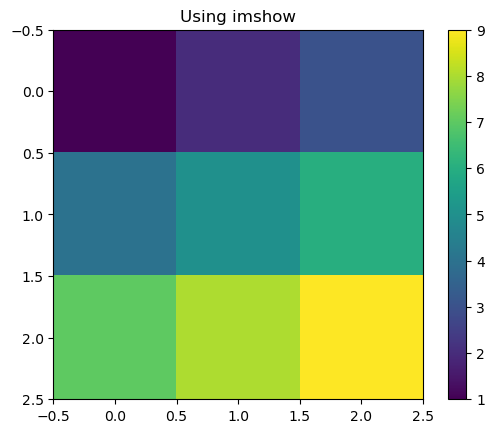

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D array
data = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# Display the array using imshow
plt.imshow(data, cmap='viridis')
plt.colorbar()
plt.title('Using imshow')
plt.show()


C:\Users\14902\AppData\Local\Temp\ipykernel_26288\211453995.py:6: RuntimeWarning: divide by zero encountered in log
  plt.contourf(np.log(x), np.log(y), data, levels=10, cmap='viridis')


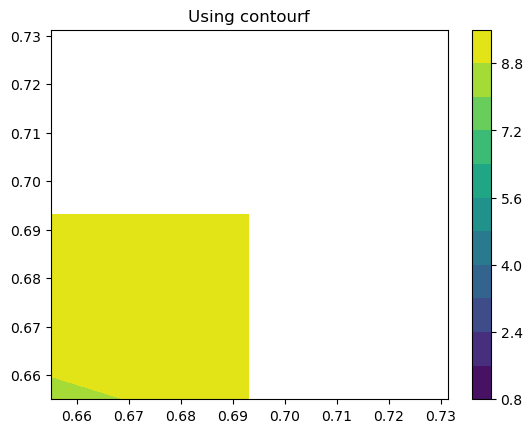

In [58]:
# Create a contour plot using contourf
# x = np.arange(0, data.shape[1])
# y = np.arange(0, data.shape[0])
# X, Y = np.meshgrid(x, y)

plt.contourf(np.log(x), np.log(y), data, levels=10, cmap='viridis')
plt.colorbar()
plt.title('Using contourf')
plt.show()

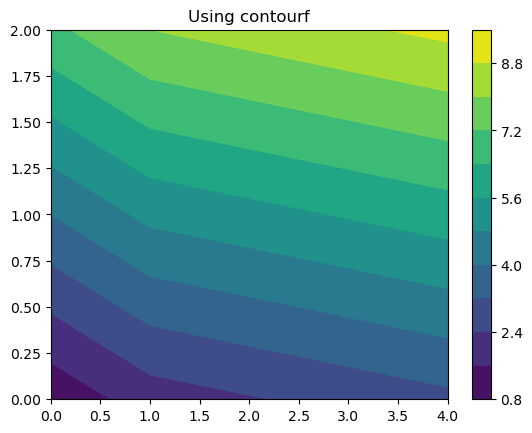

In [68]:
plt.contourf(x**2, y, data, levels=10, cmap='viridis')
plt.colorbar()
plt.title('Using contourf')
plt.show()

In [62]:
x

array([0, 1, 2])

In [66]:
y = np.arange(0, data.shape[0])
y

array([0, 1, 2])

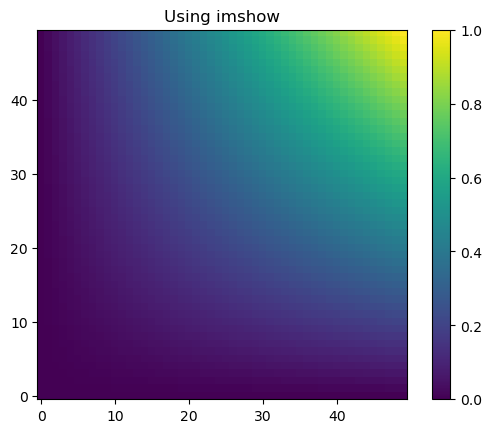

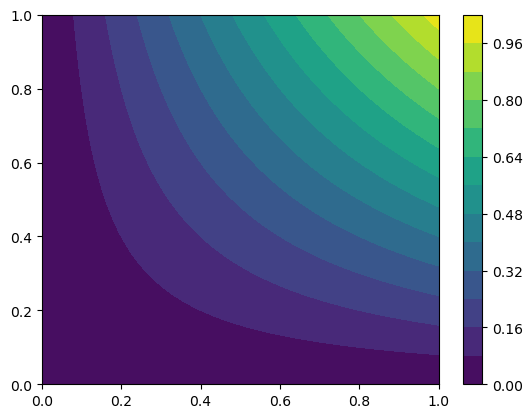

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 50x50 2D array with a regular gradient
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
data = np.outer(x, y)



fig, ax = plt.subplots()

# Display the array using imshow
sc=ax.imshow(data, cmap='viridis',origin='lower')
fig.colorbar(sc)
ax.set_title('Using imshow')

fig, ax = plt.subplots()
sc=ax.contourf(x,y , data, levels=15, cmap='viridis')
plt.colorbar(sc)

In [83]:
np.outer?

Signature:       np.outer(a, b, out=None)
Call signature:  np.outer(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function outer at 0x00000251FD687670>
File:            c:\users\14902\anaconda3\envs\sdo2022\lib\site-packages\numpy\core\numeric.py
Docstring:      
Compute the outer product of two vectors.

Given two vectors `a` and `b` of length ``M`` and ``N``, repsectively,
the outer product [1]_ is::

  [[a_0*b_0  a_0*b_1 ... a_0*b_{N-1} ]
   [a_1*b_0    .
   [ ...          .
   [a_{M-1}*b_0            a_{M-1}*b_{N-1} ]]

Parameters
----------
a : (M,) array_like
    First input vector.  Input is flattened if
    not already 1-dimensional.
b : (N,) array_like
    Second input vector.  Input is flattened if
    not already 1-dimensional.
out : (M, N) ndarray, optional
    A location where the result is stored

    .. versionadded:: 1.9.0

Returns
-------
out : (M, N) ndarray
    ``out[i, j] = a[i] * b[j]``

See also
--------
inner
einsum : ``einsum('i,j-